In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import jupyter_black

# jupyter_black.load(is_lab=True)

In [2]:
import os

print(os.getcwd())

/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Notebooks


In [3]:
df_customer_Churn = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Data/Daily_Churned_customers_JET.csv"
)

df_input_accounts = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Data/input_accounts_21_10_2022.csv"
)

df_tweets = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/Data/tweets-2022-10-21_justeattakeaway.csv"
)

In [4]:
df_tweets = pd.merge(
    left=df_tweets,
    right=df_input_accounts,
    left_on="user_id",
    right_on="user_id",
    how="left",
)
df_input_accounts = None

In [5]:
df_tweets = df_tweets[
    df_tweets.full_name.isin(["thuisbezorgd", "Just Eat Takeaway.com", "Just Eat UK"])
]


df_tweets = df_tweets[df_tweets.lang == "en"]

In [6]:
df_tweets_jet = df_tweets

## Only get english Tweets

In [7]:
# delta chrun
df_customer_Churn["d_churn"] = (
    df_customer_Churn["Churned customers"].shift(1)
    - df_customer_Churn["Churned customers"]
)

# Part 2. Data analysis of the platform’s Twitter data

## data Preprocessing

##### 1. Remove all non-character signs and stop words (Stop words are a set of commonly used words in a language that do not have any meaning. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.):

In [8]:
import warnings


def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [9]:
from nltk.corpus import stopwords
import re

from termcolor import colored
import math

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

import gensim

nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk import word_tokenize


import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from gensim.models.ldamodel import LdaModel

[nltk_data] Downloading package wordnet to /home/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
def show_vocabulary(vectorizer, word_size=15, words_per_line=10):
    words = vectorizer.get_feature_names()

    print(f"Vocabulary size: {len(words)} words")

    word_format = f"<{word_size}"
    for l in np.array_split(words, math.ceil(len(words) / words_per_line)):
        print("".join([f"{x:{word_format}}" for x in l]))


def show_bow(vectorizer, bow, word_size=15, words_per_line=8):
    words = vectorizer.get_feature_names()

    word_format = f"<{word_size}"
    for l in np.array_split(
        list(zip(words, bow)), math.ceil(len(words) / words_per_line)
    ):
        print(
            " | ".join(
                [
                    colored(f"{w:{word_format}}:{n:>2}", "grey")
                    if int(n) == 0
                    else colored(
                        f"{w:{word_format}}:{n:>2}",
                        on_color="on_yellow",
                        attrs=["bold"],
                    )
                    for w, n in l
                ]
            )
        )


def show_bow_float(vectorizer, bow, word_size=15, words_per_line=6):
    words = vectorizer.get_feature_names()

    word_format = f"<{word_size}"
    for l in np.array_split(
        list(zip(words, bow)), math.ceil(len(words) / words_per_line)
    ):
        print(
            " | ".join(
                [
                    colored(f"{w:word_format}:{float(n):>0.2f}", "grey")
                    if float(n) == 0
                    else colored(
                        f"{w:word_format}:{float(n):>0.2f}",
                        on_color="on_yellow",
                        attrs=["bold"],
                    )
                    for w, n in l
                ]
            )
        )

In [11]:
additional = [
    "rt",
    "rts",
    "retweet",
    "please",
    "ha",
    "w",
]  # we'll store additional stopwords here
swords = set().union(stopwords.words("english"), additional)

# replace all signs and stopwords in tweets and tokenize tweets (tokenization means splitting up a larger body of text into pieces such as words, keywords, phrases, symbols and other elements called tokens; in our case we can split the tweets into words)
df_tweets.drop_duplicates(subset="text", inplace=True)
df_tweets["text"] = df_tweets["text"].str.lower()

df_tweets["processed_text"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
    .apply(lambda x: [i for i in x.split() if not i in swords])
)

df_tweets["processed_text_"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
)

/tmp/ipykernel_29008/1050531540.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]
/tmp/ipykernel_29008/1050531540.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]


In [12]:
wnl = WordNetLemmatizer()


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        regex_num_ponctuation = "(\d+)|([^\w\s])"
        regex_little_words = r"(\b\w{1,2}\b)"
        regex_smiley = "(@[a-z0-9]+)\w+"
        regex_signs = "(http\S+)"
        regex_tweet_spec = "([^0-9a-z \t])"
        regex_https = " +"
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if not re.search(regex_num_ponctuation, t)
            and not re.search(regex_smiley, t)
            and not re.search(regex_signs, t)
            and not re.search(regex_tweet_spec, t)
            and not re.search(regex_little_words, t)
            and not re.search(regex_https, t)
        ]


# class LemmaTokenizer(object):
#     def __init__(self):
#         self.wnl = WordNetLemmatizer()

#     def __call__(self, articles):
#         return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [64]:
df_tweets_jet.processed_text_

9712     just eat q3 2022 trading update company adjust...
9713     we are now also offering grocery and convenien...
9714     we officially opened our sunderland office in ...
9715      hi thanks for letting us know about this plea...
9716     we were delighted to sponsor this year s by as...
                               ...                        
15345     hi rebecca thanks for reaching out we re conc...
15346     hey there james our social team are keen to l...
15347     hey tina thanks so much for sharing your expe...
15348     hey sammy thanks for bringing this to our att...
15349     hi ellie we re not pleased to see that you ve...
Name: processed_text_, Length: 5601, dtype: object

In [13]:
swords = set().union(stopwords.words("english"), additional)


count = CountVectorizer(
    stop_words=swords,
    tokenizer=LemmaTokenizer(),
    ngram_range=(1, 2),  # will create a vocabulary with 1-gram and 2-grams
    min_df=3,
    max_df=0.8,
    max_features=2000,
    lowercase=True,
    strip_accents="unicode",
)

matrix = count.fit_transform(df_tweets_jet.processed_text_)


results = pd.DataFrame(matrix.toarray(), columns=count.get_feature_names())
results

/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  warnings.warn(
/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,able drop,able get,able help,able look,able pop,able send,able share,able take,absolutely,...,year,year ago,year award,yesterday,yesterday evening,yesterday sorry,yet,yet resolved,young,young people
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
corpus = gensim.matutils.Sparse2Corpus(matrix, documents_columns=False)
id_map = dict((v, k) for k, v in count.vocabulary_.items())

In [15]:
K = 8

In [16]:
lda = LdaModel(
    corpus=corpus,
    id2word=id_map,
    num_topics=K,
    alpha="auto",
    eta="auto",
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True,
)

In [17]:
lda.print_topics()

[(0,
  '0.054*"pop" + 0.050*"order" + 0.045*"number" + 0.045*"thanks" + 0.044*"order number" + 0.041*"could" + 0.040*"pop order" + 0.038*"could pop" + 0.037*"hey" + 0.036*"thanks reaching"'),
 (1,
  '0.028*"definitely" + 0.028*"pop" + 0.025*"limited" + 0.025*"character" + 0.025*"limited character" + 0.023*"address" + 0.022*"email address" + 0.020*"reaching bringing" + 0.020*"definitely like" + 0.020*"hear pop"'),
 (2,
  '0.036*"order" + 0.032*"hey" + 0.024*"number" + 0.023*"order number" + 0.023*"would" + 0.022*"like" + 0.022*"hear" + 0.021*"take" + 0.021*"drop" + 0.015*"sorry"'),
 (3,
  '0.020*"read" + 0.017*"amp" + 0.014*"takeaway" + 0.013*"eat" + 0.013*"restaurant" + 0.013*"team" + 0.012*"food" + 0.011*"partner" + 0.010*"across" + 0.009*"people"'),
 (4,
  '0.042*"look" + 0.031*"like" + 0.023*"take" + 0.023*"detail" + 0.022*"email" + 0.019*"com" + 0.018*"order" + 0.018*"number" + 0.018*"order number" + 0.017*"send"'),
 (5,
  '0.062*"customer" + 0.038*"security" + 0.024*"extremely" + 

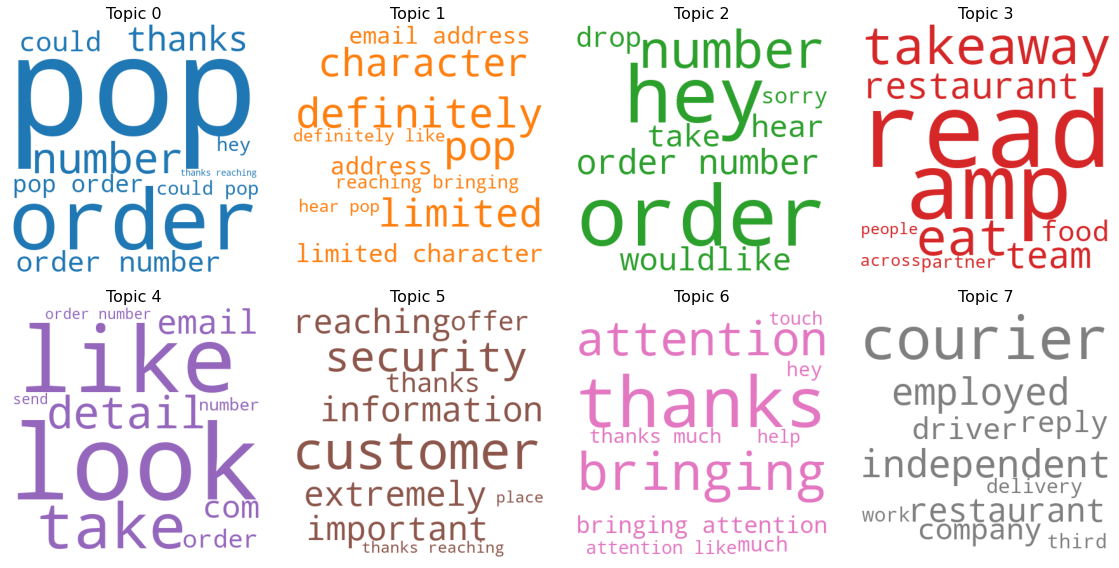

In [18]:
nb_columns = 4
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=15,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)

fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title("Topic " + str(i), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [19]:
# show_vocabulary(count)

In [20]:
lda.print_topics()

[(0,
  '0.054*"pop" + 0.050*"order" + 0.045*"number" + 0.045*"thanks" + 0.044*"order number" + 0.041*"could" + 0.040*"pop order" + 0.038*"could pop" + 0.037*"hey" + 0.036*"thanks reaching"'),
 (1,
  '0.028*"definitely" + 0.028*"pop" + 0.025*"limited" + 0.025*"character" + 0.025*"limited character" + 0.023*"address" + 0.022*"email address" + 0.020*"reaching bringing" + 0.020*"definitely like" + 0.020*"hear pop"'),
 (2,
  '0.036*"order" + 0.032*"hey" + 0.024*"number" + 0.023*"order number" + 0.023*"would" + 0.022*"like" + 0.022*"hear" + 0.021*"take" + 0.021*"drop" + 0.015*"sorry"'),
 (3,
  '0.020*"read" + 0.017*"amp" + 0.014*"takeaway" + 0.013*"eat" + 0.013*"restaurant" + 0.013*"team" + 0.012*"food" + 0.011*"partner" + 0.010*"across" + 0.009*"people"'),
 (4,
  '0.042*"look" + 0.031*"like" + 0.023*"take" + 0.023*"detail" + 0.022*"email" + 0.019*"com" + 0.018*"order" + 0.018*"number" + 0.018*"order number" + 0.017*"send"'),
 (5,
  '0.062*"customer" + 0.038*"security" + 0.024*"extremely" + 

In [21]:
names = [
    "Rugby",
    "Video Games",
    "Radio",
    "Internet",
    "Politics",
    "Cybersecurity",
    "taas",
    "rtest",
]

topic_names = {i: v for i, v in enumerate(names)}

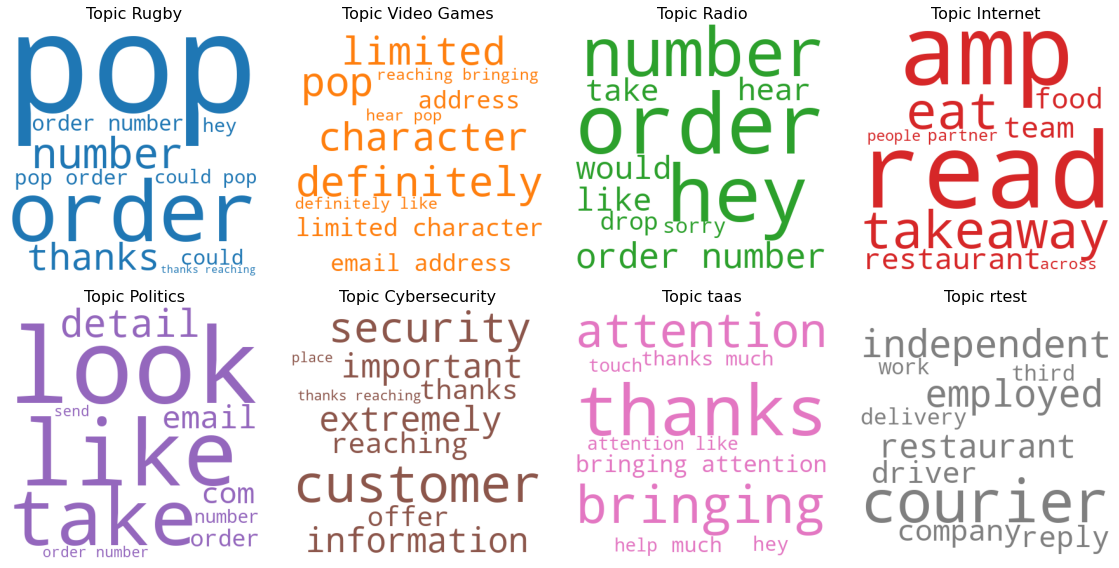

In [22]:
nb_columns = 4
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=15,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)


fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title("Topic " + str(names[i]), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [23]:
import nltk

### Important quesiton: which are the base tweets and which tweets are just tweets that are in reply to the customers 

This is important as we have to figure this out in the preprocessing simply to gain insights with respect which tweets are innovation tweets and which are not.

In [24]:
# most fequent words and trigrams

# conver the results into a list of lsits
processed_words = {}
for i, r in results.iterrows():
    processed_words[i] = list(r[r != 0].index)

df_tweets_jet["processed_words_lemma"] = processed_words.values()

df_results = pd.DataFrame(results.sum(), columns=["count_words"]).sort_values(
    by="count_words", ascending=False
)


additiona = {}
counter = 0
for i, r in df_results.iterrows():
    additiona[counter] = len(i.split())

    counter += 1


df_results["length"] = additiona.values()
# load the topics by document!

# most important single words
df_results.count_words.head(5)

# most improtant bigrams
df_results[df_results.length == 2].head(5)

# most important trigrams
df_results[df_results.length == 3].head(5)

,count_words,length


## Answering 2.1 

## simple wordcluds

## Topics 

In [25]:
# most important topics
lda.print_topics()

[(0,
  '0.054*"pop" + 0.050*"order" + 0.045*"number" + 0.045*"thanks" + 0.044*"order number" + 0.041*"could" + 0.040*"pop order" + 0.038*"could pop" + 0.037*"hey" + 0.036*"thanks reaching"'),
 (1,
  '0.028*"definitely" + 0.028*"pop" + 0.025*"limited" + 0.025*"character" + 0.025*"limited character" + 0.023*"address" + 0.022*"email address" + 0.020*"reaching bringing" + 0.020*"definitely like" + 0.020*"hear pop"'),
 (2,
  '0.036*"order" + 0.032*"hey" + 0.024*"number" + 0.023*"order number" + 0.023*"would" + 0.022*"like" + 0.022*"hear" + 0.021*"take" + 0.021*"drop" + 0.015*"sorry"'),
 (3,
  '0.020*"read" + 0.017*"amp" + 0.014*"takeaway" + 0.013*"eat" + 0.013*"restaurant" + 0.013*"team" + 0.012*"food" + 0.011*"partner" + 0.010*"across" + 0.009*"people"'),
 (4,
  '0.042*"look" + 0.031*"like" + 0.023*"take" + 0.023*"detail" + 0.022*"email" + 0.019*"com" + 0.018*"order" + 0.018*"number" + 0.018*"order number" + 0.017*"send"'),
 (5,
  '0.062*"customer" + 0.038*"security" + 0.024*"extremely" + 

In [26]:
by_get_document_topics = list(map(lda.get_document_topics, corpus))

by_bracket = lda[corpus]

##### most used words / hashtags / bigrams (trigrams)?

#### words by time of day

In [27]:
# time question
df_tweets_jet["created_at"] = pd.to_datetime(df_tweets_jet.created_at)

df_tweets_jet["year"] = pd.DatetimeIndex(df_tweets_jet.created_at).year
df_tweets_jet["month"] = pd.DatetimeIndex(df_tweets_jet.created_at).month
df_tweets_jet["day"] = pd.DatetimeIndex(df_tweets_jet.created_at).day
df_tweets_jet["hour"] = pd.DatetimeIndex(df_tweets_jet.created_at).hour

In [28]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [29]:
# count number of tweets by company by hour of day/month
df_tweets_jet.groupby(by=["hour", "full_name"]).agg({"tweet_id": "count"})

tweet_id
hour full_name                      
0    Just Eat Takeaway.com         3
1    Just Eat Takeaway.com         1
3    Just Eat Takeaway.com         1
5    Just Eat Takeaway.com        11
6    Just Eat Takeaway.com        41
7    Just Eat Takeaway.com        57
8    Just Eat Takeaway.com       127
     Just Eat UK                   1
9    Just Eat Takeaway.com       157
     Just Eat UK                 144
10   Just Eat Takeaway.com       214
     Just Eat UK                 170
11   Just Eat Takeaway.com       201
     Just Eat UK                 289
12   Just Eat Takeaway.com       196
     Just Eat UK                 255
13   Just Eat Takeaway.com       181
     Just Eat UK                 236
14   Just Eat Takeaway.com       232
     Just Eat UK                 414
15   Just Eat Takeaway.com       245
     Just Eat UK                 307
16   Just Eat Takeaway.com       188
     Just Eat UK                 291
17   Just Eat Takeaway.com       121
     Just Eat UK                 222
18   Just Eat Takeaway.com       123
     Just Eat UK                 197
19   Just Eat Takeaway.com       104
     Just Eat UK                 160
20   Just Eat Takeaway.com        96
     Just Eat UK                 180
21   Just Eat Takeaway.com        80
     Just Eat UK                 292
22   Just Eat Takeaway.com        51
     Just Eat UK                  10
23   Just Eat Takeaway.com         3

In [30]:
df_tweets_jet.groupby(by=["day", "full_name"]).agg({"tweet_id": "count"})

tweet_id
day full_name                      
1   Just Eat Takeaway.com        85
    Just Eat UK                 296
2   Just Eat Takeaway.com        70
    Just Eat UK                  82
3   Just Eat Takeaway.com        75
...                             ...
29  Just Eat UK                 105
30  Just Eat Takeaway.com        87
    Just Eat UK                 136
31  Just Eat Takeaway.com        36
    Just Eat UK                  41

[62 rows x 1 columns]

In [31]:
df_tweets_jet.groupby(by=["month", "full_name"]).agg({"tweet_id": "count"})

tweet_id
month full_name                      
1     Just Eat Takeaway.com       172
2     Just Eat Takeaway.com       173
3     Just Eat Takeaway.com       233
4     Just Eat Takeaway.com       243
5     Just Eat Takeaway.com       224
6     Just Eat Takeaway.com       224
7     Just Eat Takeaway.com       214
8     Just Eat Takeaway.com       148
      Just Eat UK                 210
9     Just Eat Takeaway.com       178
      Just Eat UK                1586
10    Just Eat Takeaway.com       201
      Just Eat UK                1372
11    Just Eat Takeaway.com       238
12    Just Eat Takeaway.com       185

Goal from here on: make linegraphs showing the development of each company and also show the words used by company or in aggegate


additionally, use the topics labelled above and look at how the different companies stack up (eg one company might have problems with the customer service so they load more frequrently on this )

also words by topic




In [32]:
df_tweets_jet

,tweet_id,user_id,text,conversation_id,created_at,fetched_at,in_reply_to_user_id,lang,geo,possibly_sensitive,...,withheld,user_name,full_name,processed_text,processed_text_,processed_words_lemma,year,month,day,hour
9712,1582597815922221056,272030125,just eat https://t.co/irejqclqk3 q3 2022 tradi...,1582597815922221056,2022-10-19 05:01:37+00:00,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,NaN,JustEatTakeaway,Just Eat Takeaway.com,"[eat, q3, 2022, trading, update, company, adju...",just eat q3 2022 trading update company adjust...,"[ahead, company, eat, trading, trading update,...",2022,10,19,5
9713,1582323317343940610,272030125,we are now also offering grocery and convenien...,1582323317343940610,2022-10-18 10:50:51+00:00,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,NaN,JustEatTakeaway,Just Eat Takeaway.com,"[also, offering, grocery, convenience, items, ...",we are now also offering grocery and convenien...,"[also, available, convenience, grocery, item, ...",2022,10,18,10
9714,1582307018588983298,272030125,we officially opened our #sunderland office in...,1582307018588983298,2022-10-18 09:46:05+00:00,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,NaN,JustEatTakeaway,Just Eat Takeaway.com,"[officially, opened, sunderland, office, uk, l...",we officially opened our sunderland office in ...,"[act, area, catering, customer, customer servi...",2022,10,18,9
9715,1581706388799385600,272030125,"@kellyshoebridge hi, thanks for letting us kno...",1581561895705722880,2022-10-16 17:59:24+00:00,2022-10-21T11:14:44.000Z,1.268105e+18,en,NaN,False,...,NaN,JustEatTakeaway,Just Eat Takeaway.com,"[hi, thanks, letting, us, know, dm, us, order,...",hi thanks for letting us know about this plea...,"[know, know order, letting, letting know, look...",2022,10,16,17
9716,1580857945604378625,272030125,we were delighted to sponsor this year's @blac...,1580857945604378625,2022-10-14 09:47:59+00:00,2022-10-21T11:14:44.000Z,NaN,en,NaN,False,...,NaN,JustEatTakeaway,Just Eat Takeaway.com,"[delighted, sponsor, year, part, stem, program...",we were delighted to sponsor this year s by as...,"[career, career tech, consider, consider caree...",2022,10,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15345,1563893745338155009,25320756,"@beccaturnbull13 hi rebecca, thanks for reachi...",1563519013795143680,2022-08-28 14:18:19+00:00,2022-10-21T11:15:18.000Z,1.470773e+18,en,NaN,False,...,NaN,JustEatUK,Just Eat UK,"[hi, rebecca, thanks, reaching, concerned, hea...",hi rebecca thanks for reaching out we re conc...,"[concerned, concerned hear, customer, customer...",2022,8,28,14
15346,1563891421941305344,25320756,@bickerdykejames hey there james! our social t...,1563884654754758656,2022-08-28 14:09:05+00:00,2022-10-21T11:15:18.000Z,1.498603e+18,en,NaN,False,...,NaN,JustEatUK,Just Eat UK,"[hey, james, social, team, keen, lend, hand, t...",hey there james our social team are keen to l...,"[arrived, could, could order, hand, hey, hey j...",2022,8,28,14
15347,1563890523429081091,25320756,"@tina12580 hey tina, thanks so much for sharin...",1526819879076044800,2022-08-28 14:05:31+00:00,2022-10-21T11:15:18.000Z,3.672719e+07,en,NaN,False,...,NaN,JustEatUK,Just Eat UK,"[hey, tina, thanks, much, sharing, experience,...",hey tina thanks so much for sharing your expe...,"[experience, hear, hey, much, sent, sharing, s...",2022,8,28,14
15348,1563886326495252481,25320756,"@sammyinside hey sammy, thanks for bringing th...",1563881693014118400,2022-08-28 13:48:50+00:00,2022-10-21T11:15:18.000Z,2.990449e+09,en,NaN,False,...,NaN,JustEatUK,Just Eat UK,"[hey, sammy, thanks, bringing, attention, disa...",hey sammy thanks for bringing this to our att...,"[attention, bringing, bringing attention, clos...",2022,8,28,13


In [33]:
# count words by hour of day and take max words at time of day/month
df_tweets_jet.processed_words_lemma

9712     [ahead, company, eat, trading, trading update,...
9713     [also, available, convenience, grocery, item, ...
9714     [act, area, catering, customer, customer servi...
9715     [know, know order, letting, letting know, look...
9716     [career, career tech, consider, consider caree...
                               ...                        
15345    [concerned, concerned hear, customer, customer...
15346    [arrived, could, could order, hand, hey, hey j...
15347    [experience, hear, hey, much, sent, sharing, s...
15348    [attention, bringing, bringing attention, clos...
15349    [best, best experience, closer, closer look, c...
Name: processed_words_lemma, Length: 5601, dtype: object

## 2.2 Please, compute the sentiment scores for each tweet using nltk (vader) library or any other library of your choice. You may also engineer any additional variables based on computed sentiment scores. How could you describe the platform’s tweets based on their sentiment scores? (1 slide)

here we should find the sentiment score of each document; classify it and then build a regression on this 

In [34]:
import nltk.sentiment.vader as vd
from nltk import download

download("vader_lexicon")

sia = vd.SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize

df_tweets_jet["sentiment_score"] = df_tweets_jet["processed_words_lemma"].apply(
    lambda x: sum(
        [sia.polarity_scores(i)["compound"] for i in word_tokenize(" ".join(x))]
    )
)
df_tweets_jet[["processed_words_lemma", "sentiment_score"]].head(n=10)
df_tweets_jet["sentiment_score"].apply(
    lambda x: round(
        x,
    )
).value_counts()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/angelo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


 1     1485
 0     1353
 2     1094
 3      688
 4      584
 5      170
 6      106
-1       91
 7       12
 8        8
-2        7
 10       1
 11       1
 9        1
Name: sentiment_score, dtype: int64

In [35]:
df_tweets_jet["round_sentiment"] = df_tweets_jet["sentiment_score"].apply(
    lambda x: round(
        x,
    )
)

# create sentiment score for regression eg a dummy


df_tweets_jet["rank_round_sentiment"] = df_tweets_jet["round_sentiment"].rank(
    method="first"
)

df_tweets_jet["quantile_round_sentiment"] = df_tweets_jet[
    "rank_round_sentiment"
].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)

## put sentiment scores into quantiles and then from quantiles  into dummies

plot the sentiment score distribution

In [36]:
df_tweets_jet.sentiment_score

9712     0.0000
9713     0.0000
9714     0.0000
9715     1.1124
9716     1.5786
          ...  
15345    3.9793
15346    2.4521
15347    1.1479
15348    1.2426
15349    3.3926
Name: sentiment_score, Length: 5601, dtype: float64

#### create a 3-4 class sentiment score  (-2 to 0 is not good; etc)

#### group by company by sentiment scorem

#### see how the sentiment socre develops over time per comapny

## simple wordclouds

In [37]:
# Join the different processed titles together.
long_string = []
for i in df_tweets_jet.processed_words_lemma:
    long_string.extend(i)


long_string = " ".join(long_string)

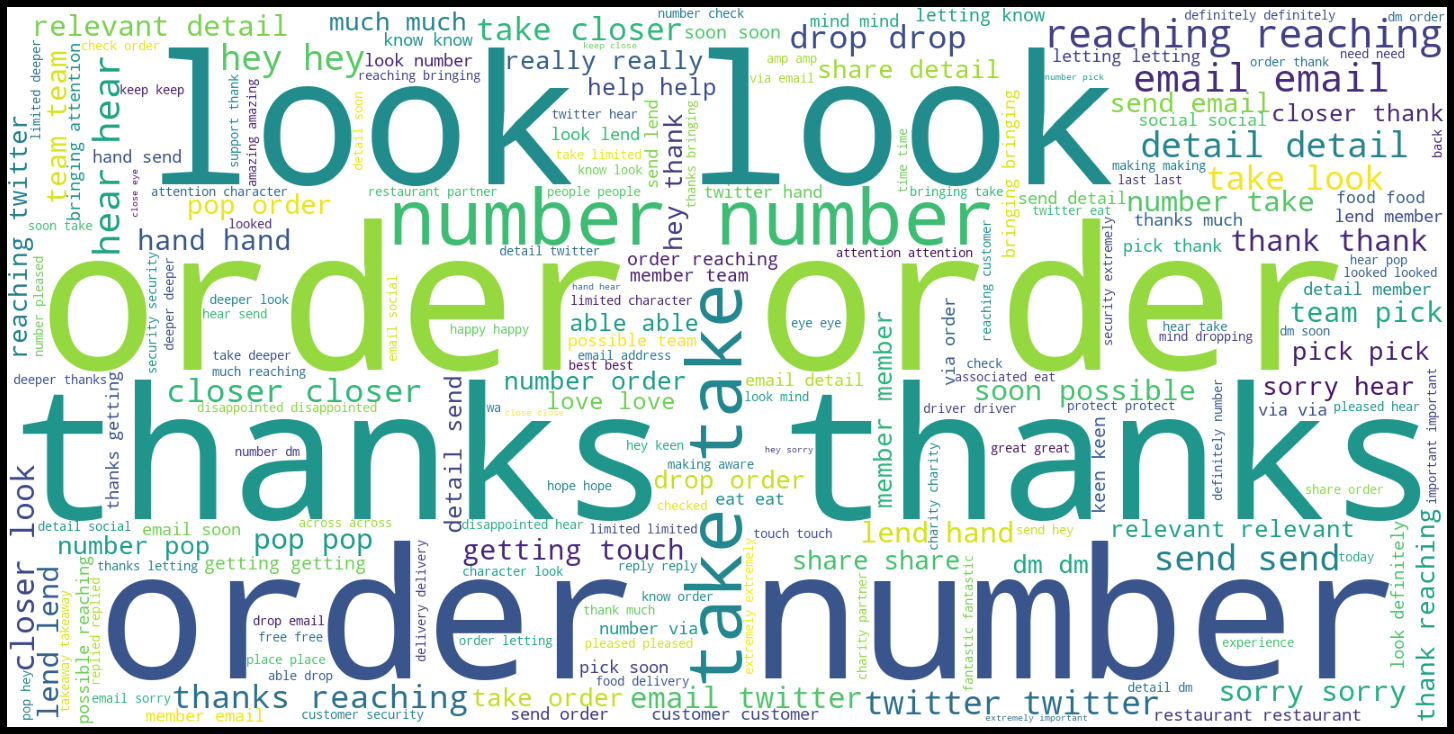

In [38]:
# Create a WordCloud object
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    max_words=200,
    contour_width=3,
    contour_color="steelblue",
)


# Generate a word cloud
wordcloud.generate(str(long_string))

# Visualize the word cloud
wordcloud.to_image()


plt.figure(figsize=(20, 10), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

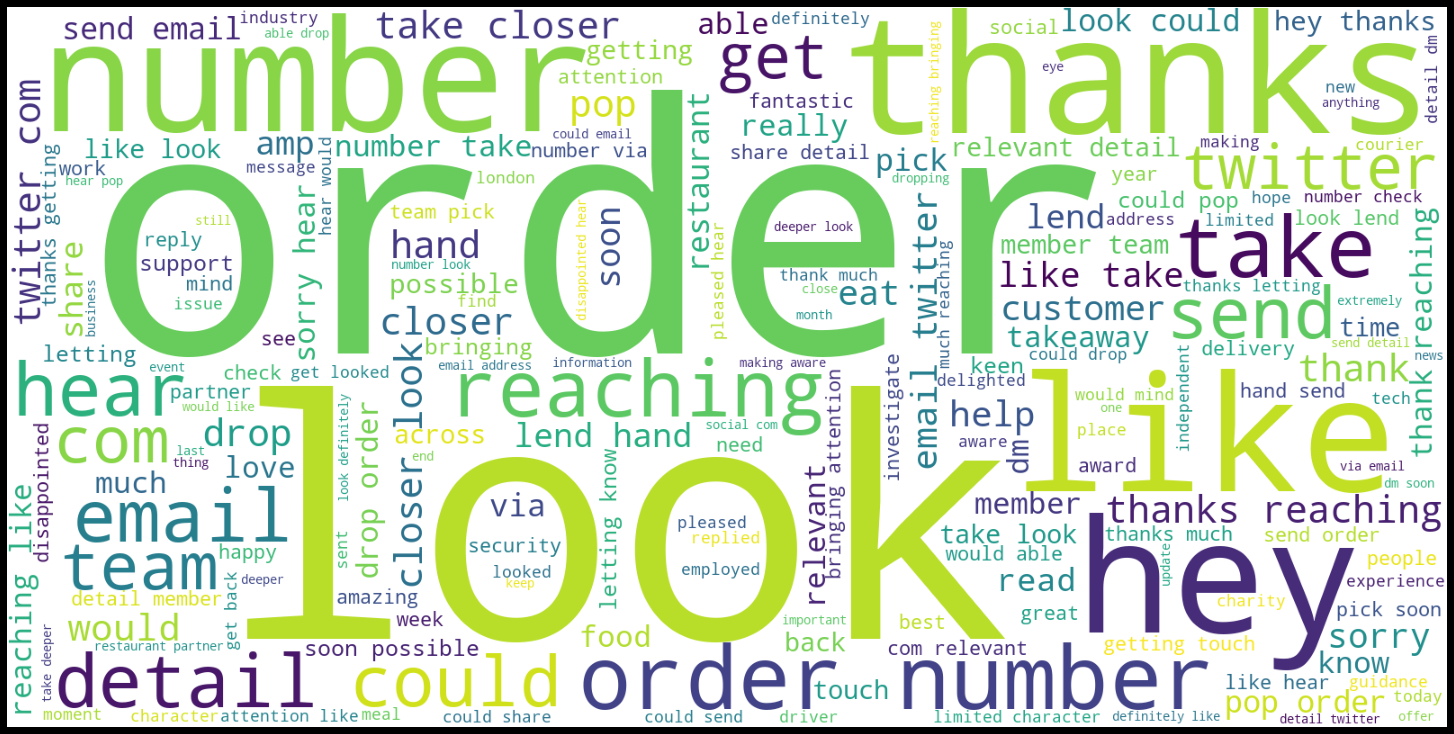

In [39]:
# Create a WordCloud object
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    max_words=200,
    contour_width=3,
    contour_color="steelblue",
)


# Generate a word cloud
wordcloud.generate_from_frequencies(dict(df_results.count_words))

# Visualize the word cloud
wordcloud.to_image()


plt.figure(figsize=(20, 10), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# 3 What features of the platform’s tweets are related to higher / lower user engagement with the tweets as measured by the number of  likes, retweets, or replies per tweet?




What features of the platform’s tweets are related to higher / lower user engagement with the tweets as measured by the number of  likes, retweets, or replies per tweet?

In [40]:
df_tweets_jet.describe()

,tweet_id,user_id,conversation_id,in_reply_to_user_id,geo,retweet_count,reply_count,like_count,quote_count,retweeted_id,replied_to_id,quoted_id,withheld,year,month,day,hour,sentiment_score,round_sentiment,rank_round_sentiment
count,5.601000e+03,5.601000e+03,5.601000e+03,3.962000e+03,0.0,5601.000000,5601.000000,5601.000000,5601.000000,5.601000e+03,5.601000e+03,5.601000e+03,0.0,5601.000000,5601.000000,5601.000000,5601.00000,5601.000000,5601.000000,5601.00000
mean,1.370806e+18,1.324880e+08,1.369583e+18,4.506156e+17,NaN,2.118193,0.333155,2.978575,0.149259,2.093520e+16,1.064136e+18,7.791647e+15,NaN,2020.567399,8.116229,14.595965,14.43278,1.736551,1.719693,2801.00000
std,3.133048e+17,1.222989e+08,3.133702e+17,6.171869e+17,NaN,38.517931,0.922955,8.591186,0.874767,1.487381e+17,7.029595e+17,9.369837e+16,NaN,2.295213,2.691831,9.086103,3.79452,1.581834,1.604676,1617.01376
min,1.193541e+17,2.532076e+07,1.193541e+17,7.779170e+05,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,NaN,2011.000000,1.000000,1.000000,0.00000,-2.315100,-2.000000,1.00000
25%,1.189526e+18,2.532076e+07,1.187830e+18,1.988412e+08,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,NaN,2019.000000,7.000000,7.000000,11.00000,0.476700,0.000000,1401.00000
50%,1.566542e+18,2.532076e+07,1.565792e+18,1.308906e+09,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000e+00,1.566139e+18,-1.000000e+00,NaN,2022.000000,9.000000,14.000000,14.00000,1.347600,1.000000,2801.00000
75%,1.575920e+18,2.720301e+08,1.575574e+18,1.097968e+18,NaN,0.000000,0.000000,1.000000,0.000000,-1.000000e+00,1.575846e+18,-1.000000e+00,NaN,2022.000000,10.000000,22.000000,17.00000,2.685500,3.000000,4201.00000
max,1.582845e+18,2.720301e+08,1.582829e+18,1.582472e+18,NaN,1880.000000,35.000000,322.000000,33.000000,1.541436e+18,1.582829e+18,1.526856e+18,NaN,2022.000000,12.000000,31.000000,23.00000,11.286800,11.000000,5601.00000


#### Dependent variable preparation
As dependent variables, you may use the number of likes, retweets and / or replies to each tweet of the platform.

## IMPORTANT: this outcome variable requires the poisson distribution stuff!

In [41]:
df_regression = df_tweets_jet.loc[
    :, ["like_count", "reply_count", "retweet_count", "quantile_round_sentiment"]
]
df_tweets_jet.drop(
    ["rank_round_sentiment", "quantile_round_sentiment"], axis=1, inplace=True
)
df_regression.describe()

,like_count,reply_count,retweet_count
count,5601.000000,5601.000000,5601.000000
mean,2.978575,0.333155,2.118193
std,8.591186,0.922955,38.517931
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,322.000000,35.000000,1880.000000


In [42]:
# make a score based on the range (as I am not sure how the ranges behave)
# A value in either column can get one of 5 values based on in which quartile it finishes; obviously the higher the better
# note: these quantile are less than perfect as I have to rank first, which defeats the true purpose
df_regression["rank_like_count"] = df_regression["like_count"].rank(method="first")

df_regression["quantile_like_count"] = df_regression["rank_like_count"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)

df_regression["rank_reply_count"] = df_regression["reply_count"].rank(method="first")

df_regression["quantile_reply_count"] = df_regression["rank_reply_count"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)


df_regression["rank_retweet_count"] = df_regression["retweet_count"].rank(
    method="first"
)

df_regression["quantile_retweet_count"] = df_regression["rank_retweet_count"].transform(
    lambda x: pd.qcut(
        x.rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
    )
)

In [43]:
df_regression.drop(
    ["rank_like_count", "rank_reply_count", "rank_retweet_count"], axis=1, inplace=True
)

In [44]:
df_regression = df_regression.astype(
    {
        "quantile_retweet_count": "int",
        "quantile_reply_count": "int",
        "quantile_like_count": "int",
    }
)

In [45]:
# creating the finel outcome vairable
df_regression["engagement"] = (
    df_regression["quantile_retweet_count"]
    + df_regression["quantile_reply_count"]
    + df_regression["quantile_like_count"]
)

#### Create dummy per company

In [46]:
tmp = pd.get_dummies(df_tweets_jet.full_name, dummy_na=False)

In [47]:
df_regression = pd.merge(
    left=df_regression, right=tmp, left_index=True, right_index=True, how="inner"
)

#### Create independent variable

### Create an aggregated user engagement variable for the outcome

As independent variables, you may use any relevant features from the Twitter data set, any additional features you created, and the sentiment scores from point 2.2 

In [48]:
# summer/Winter/ quarters
df_tweets_jet["season_quarters"] = pd.DatetimeIndex(df_tweets_jet.created_at).quarter

# a simple trick to create "seasons"
df_tweets_jet["season"] = df_tweets_jet.month % 12 // 3 + 1

In [49]:
# create corresponding dummies
tmp = pd.get_dummies(df_tweets_jet.season_quarters, dummy_na=False, prefix="quarter")
df_regression = pd.merge(
    left=df_regression, right=tmp, left_index=True, right_index=True, how="inner"
)


tmp = pd.get_dummies(df_tweets_jet.season, dummy_na=False, prefix="season")
df_regression = pd.merge(
    left=df_regression,
    right=tmp,
    left_index=True,
    right_index=True,
    how="inner",
)

In [50]:
df_tweets_jet[df_tweets_jet.replied_to_id.isna()]

,tweet_id,user_id,text,conversation_id,created_at,fetched_at,in_reply_to_user_id,lang,geo,possibly_sensitive,...,processed_text_,processed_words_lemma,year,month,day,hour,sentiment_score,round_sentiment,season_quarters,season


In [51]:
# year dummy

In [52]:
# year dummy
tmp = pd.get_dummies(df_tweets_jet.year, dummy_na=False, prefix="year")
df_regression = pd.merge(
    left=df_regression, right=tmp, left_index=True, right_index=True, how="inner"
)

In [53]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour',
       'sentiment_score', 'round_sentiment', 'season_quarters', 'season'],
      dtype='object')

### Important quesiton: which are the base tweets and which tweets are just tweets that are in reply to the customers 

In [54]:
# make dummy if replied to or not
df_tweets_jet.replied_to_id.nunique()

3786

In [55]:
# make dummy if tweet was in reply to a user
df_tweets_jet.in_reply_to_user_id.nunique()

3265

In [56]:
# make dummy if tweet was in reply to a user
df_tweets_jet.in_reply_to_user_id

9712              NaN
9713              NaN
9714              NaN
9715     1.268105e+18
9716              NaN
             ...     
15345    1.470773e+18
15346    1.498603e+18
15347    3.672719e+07
15348    2.990449e+09
15349    3.456941e+07
Name: in_reply_to_user_id, Length: 5601, dtype: float64

In [57]:
# important word length count per tweet (so the length of the list in question)
df_tweets_jet["imp_word_len"] = df_tweets_jet.processed_words_lemma.str.len()

In [58]:
#
df_tweets_jet.sentiment_score.describe()

count    5601.000000
mean        1.736551
std         1.581834
min        -2.315100
25%         0.476700
50%         1.347600
75%         2.685500
max        11.286800
Name: sentiment_score, dtype: float64

In [59]:
# make a dummy for the topic classigfication made by lda

### 3.1 Is the use of positive / negative emotional words in the company’s tweets (original posts or replies) related to higher / lower user engagement as measured by the number of  likes, retweets? (1 slide)


##### sentiment scores?

In [60]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour',
       'sentiment_score', 'round_sentiment', 'season_quarters', 'season',
       'imp_word_len'],
      dtype='object')

### 3.2 Do your findings hold for any time period or can you observe any outstanding time or seasonal patterns? For your analysis you may check any periods of interest, for example, covid-19 lockdowns, summer months, holidays, weekly patterns, time of the day patterns. (1 slide)

Create: winter, summer, dummies

#### subset regression on different time of the year (summer vs winter ) but also a normal plot should help here!

### 3.3 Please, check whether user engagement with tweets of JustEatTakeaway.com is associated (or correlated) with customer churn? Do you observe any temporal patterns in this association, i.e. does this association differ depending what period you consider? How can you interpret the observed associations? (1 slide)


Create: winter, summer, dummies!! use interaction analysis!

Create an aggregated user engagement variable for the outcome
### use the cahnge in customer churn here as well

#### regression of engagement with 

In [61]:
df_tweets_jet.columns

Index(['tweet_id', 'user_id', 'text', 'conversation_id', 'created_at',
       'fetched_at', 'in_reply_to_user_id', 'lang', 'geo',
       'possibly_sensitive', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'retweeted_id', 'replied_to_id', 'quoted_id', 'withheld',
       'user_name', 'full_name', 'processed_text', 'processed_text_',
       'processed_words_lemma', 'year', 'month', 'day', 'hour',
       'sentiment_score', 'round_sentiment', 'season_quarters', 'season',
       'imp_word_len'],
      dtype='object')

In [62]:
df_tweets_jet.processed_words_lemma

9712     [ahead, company, eat, trading, trading update,...
9713     [also, available, convenience, grocery, item, ...
9714     [act, area, catering, customer, customer servi...
9715     [know, know order, letting, letting know, look...
9716     [career, career tech, consider, consider caree...
                               ...                        
15345    [concerned, concerned hear, customer, customer...
15346    [arrived, could, could order, hand, hey, hey j...
15347    [experience, hear, hey, much, sent, sharing, s...
15348    [attention, bringing, bringing attention, clos...
15349    [best, best experience, closer, closer look, c...
Name: processed_words_lemma, Length: 5601, dtype: object

In [63]:
df_regression.columns

Index(['like_count', 'reply_count', 'retweet_count',
       'quantile_round_sentiment', 'quantile_like_count',
       'quantile_reply_count', 'quantile_retweet_count', 'engagement',
       'Just Eat Takeaway.com', 'Just Eat UK', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4', 'season_1', 'season_2', 'season_3',
       'season_4', 'year_2011', 'year_2012', 'year_2013', 'year_2014',
       'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020',
       'year_2021', 'year_2022'],
      dtype='object')